## Assesement of gene phenotypic consistency (Figs 3E & 3F)

Calculate mAP to assess phenotypic consistency of each gene (retrieval its guides against other genes' guides).

In [1]:
import random

import numpy as np
import pandas as pd
import plotnine as gg
from pycytominer import aggregate

from map_utils.map import calculate_map
from map_utils.plot import plot_map_x3_hue, set_plotting_style
from cell_health_utils import get_6well_plate_pairs, get_cell_line_colors

In [2]:
set_plotting_style()
cell_lines = ["A549", "ES2", "HCC44"]
cell_line_colors = get_cell_line_colors()

phen_activity_results = pd.read_csv("results/phenotypic_activity_map.csv")

ch_mad_path = "data/profiles/cell_health_profiles_merged_wholeplate_normalized_featureselected.tsv.gz"
profiles = pd.read_csv(ch_mad_path, sep="\t")
print(profiles.shape)

(3456, 513)


In [ ]:
replicable_perts = (
    phen_activity_results[(phen_activity_results["p < 0.05"])]
    .groupby("Cell type")["Metadata_pert_name"]
    .unique()
)
ch_df_6well = pd.concat(
    [get_6well_plate_pairs(profiles, cell_type) for cell_type in cell_lines], axis=0
)
ch_df_6well.drop_duplicates(inplace=True)

ch_df_agg = aggregate(
    ch_df_6well,
    strata=["Metadata_pert_name", "Metadata_gene_name", "Metadata_cell_line"],
    features="infer",
)

replicable_genes = {}
for cell_type in ch_df_agg.Metadata_cell_line.unique():
    replicable_genes[cell_type] = (
        ch_df_agg[
            (ch_df_agg["Metadata_cell_line"] == cell_type)
            & (ch_df_agg["Metadata_pert_name"].isin(replicable_perts[cell_type]))
        ].Metadata_gene_name.value_counts()
        > 1
    ).index.tolist()

In [4]:
pair_config = {
    "pos_sameby": {"all": ["Metadata_gene_name"], "any": []},
    "pos_diffby": {"all": [], "any": []},
    "neg_sameby": {"all": [], "any": []},
    "neg_diffby": {"all": ["Metadata_gene_name"], "any": []},
}

map_config = {
    "null_size": 10000,
    "groupby_columns": ["Metadata_gene_name"],
}

results = []

for cell_type in ch_df_agg.Metadata_cell_line.unique():
    print(f"\nProcessing cell type: {cell_type}")
    df = ch_df_agg.query(
        "Metadata_cell_line == @cell_type and Metadata_gene_name in @replicable_genes[@cell_type]"
    ).reset_index(drop=True)
    map_results = calculate_map(df, pair_config, map_config)
    map_results["cell_type"] = cell_type
    results.append(map_results)

results = pd.concat(results)
results["markers"] = np.where(results["p_value"] < 0.05, "p<0.05", "p>=0.05")
results["const"] = 1
results.rename(columns={"cell_type": "Cell type"}, inplace=True)


Processing cell type: A549


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


Processing cell type: ES2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.10/site-packages/copairs/compute.py:152: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]


Processing cell type: HCC44


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.10/site-packages/copairs/compute.py:152: RuntimeWarning: invalid value encountered in divide


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/dgx1nas1/storage/data/akalinin/projects/map/map_utils/plot.py:274: UserWarning: The figure layout has changed to tight


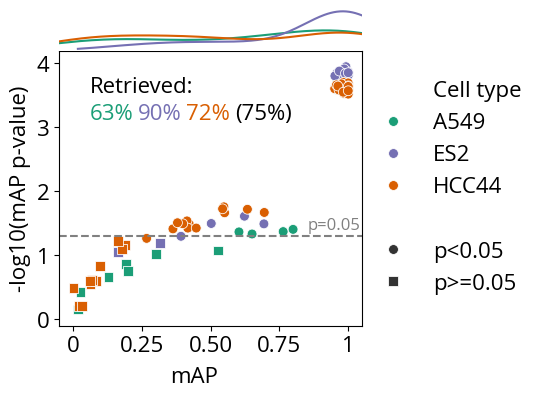

In [5]:
results_jitter = results.copy()
pvalue_jitter_strength = 0.1
map_jitter_strength = 0.05
results_jitter["-log10(mAP p-value)"] = results_jitter[
    "-log10(mAP p-value)"
] + np.random.uniform(
    -pvalue_jitter_strength, pvalue_jitter_strength, results_jitter.shape[0]
)
results_jitter["mAP"] = results_jitter["mAP"] + np.random.uniform(
    -map_jitter_strength, map_jitter_strength, results_jitter.shape[0]
)
results_jitter["mAP"] = results_jitter["mAP"].clip(0, 1)
results_jitter["-log10(mAP p-value)"] = results_jitter["-log10(mAP p-value)"].clip(0, 5)

plot_map_x3_hue(
    results_jitter,
    "const",
    "",
    hue_col="Cell type",
    palette=cell_line_colors,
    row=None,
    move_legend="center left",
    pr_x=0.1,
    pr_y=0.75,
    l_x=1.15,
    l_y=0.8,
    figure="Fig3E",
    save_path="figures",
)

### Plot individual genes

In [6]:
random.seed(0)
gene_counts = results[results["p < 0.05"]].Metadata_gene_name.value_counts()
genes_consistent_acorss_cell_types = sorted(gene_counts[gene_counts > 1].index)
genes_consistent_acorss_cell_types = random.sample(
    sorted(gene_counts[gene_counts > 1].index), 18
)
consustent_results = results.query(
    "Metadata_gene_name in @genes_consistent_acorss_cell_types"
)

/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 4 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/Fig3F.png
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 8 x 4 in image.
/dgx1nas1/storage/data/akalinin/miniconda3/envs/map_benchmark/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/Fig3F.svg


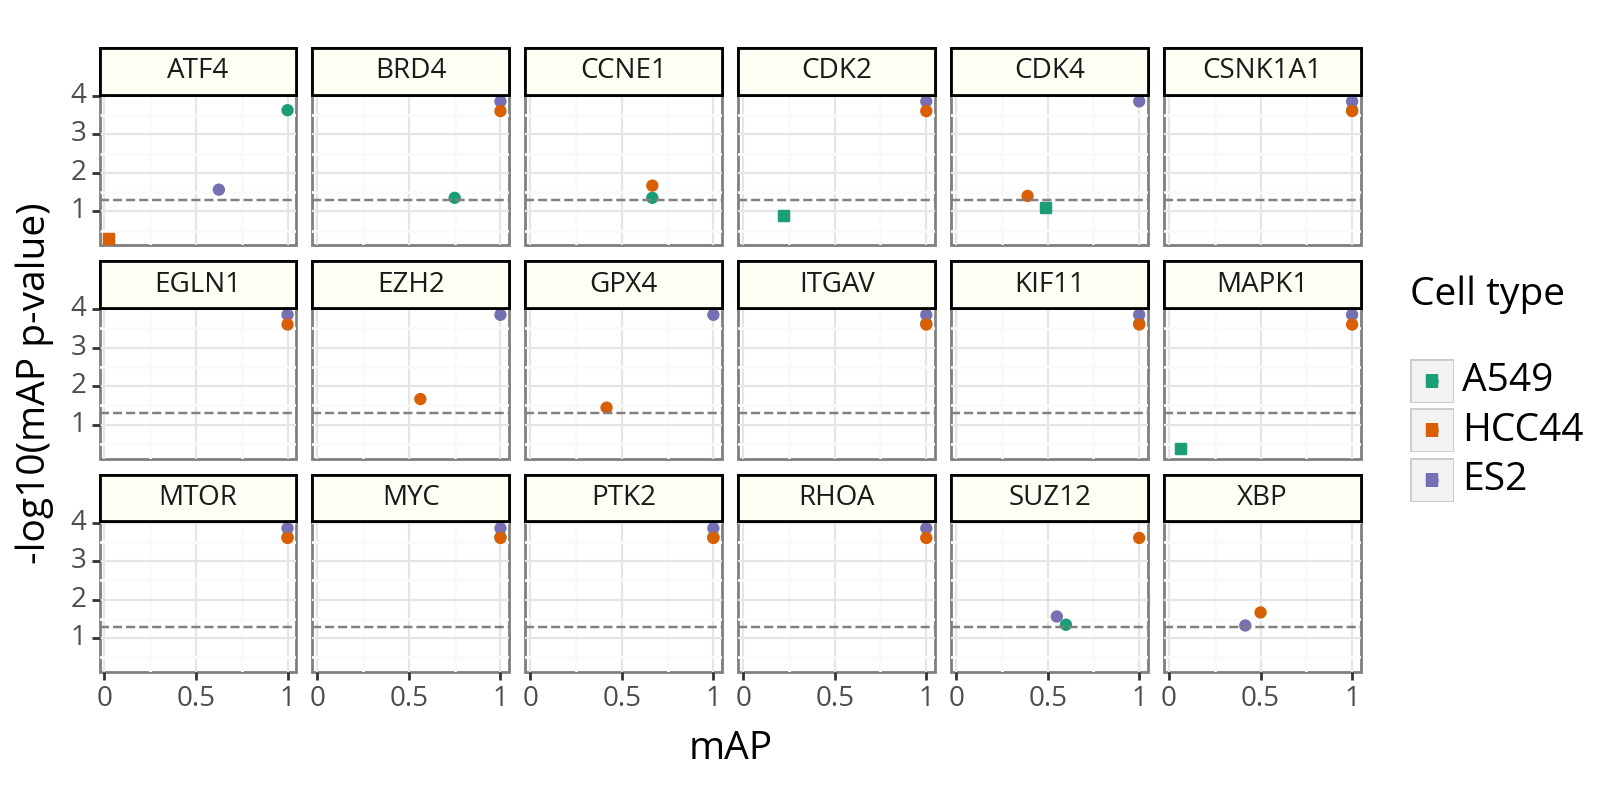

<Figure Size: (800 x 400)>

In [7]:
gene_gg = (
    gg.ggplot(
        consustent_results, gg.aes(x="mAP", y="-log10(mAP p-value)", color="Cell type")
    )
    + gg.geom_point(
        data=consustent_results[~consustent_results["p < 0.05"]], shape="s", size=1.5
    )
    + gg.geom_point(
        data=consustent_results[consustent_results["p < 0.05"]], shape="o", size=1.5
    )
    + gg.geom_hline(yintercept=-np.log10(0.05), linetype="dashed", color="grey")
    + gg.theme_bw()
    + gg.xlab("mAP")
    + gg.ylab("-log10(mAP p-value)")
    + gg.facet_wrap("~Metadata_gene_name", ncol=6)
    + gg.scale_color_manual(values=cell_line_colors)
    + gg.scale_x_continuous(breaks=[0, 0.5, 1.0])
    + gg.theme(
        strip_background=gg.element_rect(colour="black", fill="#fdfff4"),
        axis_text=gg.element_text(size=10),
        text=gg.element_text(family="Open Sans", size=14),
        axis_title=gg.element_text(family="Open Sans", size=14),
        legend_title=gg.element_text(margin={"b": 20}),
        strip_text=gg.element_text(size=10, family="Open Sans"),
        figure_size=(8, 4),
    )
)

output_file = "figures/Fig3F"
gene_gg.save(f"{output_file}.png", dpi=500)
gene_gg.save(f"{output_file}.svg")

gene_gg